In [1]:
import pandas as pd
import numpy as np

In [2]:
past_climate_data_df = pd.read_csv("past_climate_data.csv", index_col=["year", "month"])
future_climate_data_df = pd.read_csv("future_climate_data.csv", index_col=["year", "month"])

In [3]:
from datetime import datetime
from tesi.zappai.repositories.copernicus_data_store_api import (
    ERA5_EXCLUSIVE_VARIABLES,
    CMIP5_VARIABLES,
)

FEATURES = [*ERA5_EXCLUSIVE_VARIABLES, "sin_year", *CMIP5_VARIABLES]
TARGET = ERA5_EXCLUSIVE_VARIABLES


def add_sin_year(df: pd.DataFrame):
    # Reset the index to access the multi-index columns
    df_reset = df.reset_index()

    # Convert year and month to a single time representation (fractional year)
    df_reset.drop(columns=["sin_year"], errors="ignore")
    # Create sin and cos features
    df_reset["sin_year"] = np.sin(2 * np.pi * (df_reset["month"] - 1) / 12)

    # Optionally, set the index back to the original if needed
    df_reset = df_reset.set_index(["year", "month"])
    return df_reset


past_climate_data_df = add_sin_year(past_climate_data_df)
past_climate_data_df = past_climate_data_df[FEATURES]
future_climate_data_df = add_sin_year(future_climate_data_df)
future_climate_data_df = future_climate_data_df[
    ["sin_year", *CMIP5_VARIABLES]
]
past_climate_data_df.columns, future_climate_data_df.columns

2024-06-10 02:45:09.330387: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 02:45:09.332656: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 02:45:09.363636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 02:45:09.973251: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(Index(['soil_temperature_level_1', 'volumetric_soil_water_layer_1', 'sin_year',
        '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature',
        'evaporation', 'total_precipitation', 'surface_pressure',
        'surface_solar_radiation_downwards',
        'surface_thermal_radiation_downwards'],
       dtype='object'),
 Index(['sin_year', '10m_u_component_of_wind', '10m_v_component_of_wind',
        '2m_temperature', 'evaporation', 'total_precipitation',
        'surface_pressure', 'surface_solar_radiation_downwards',
        'surface_thermal_radiation_downwards'],
       dtype='object'))

In [4]:
x_df = past_climate_data_df[FEATURES]
y_df = past_climate_data_df[TARGET]

In [5]:
perc_70 = int(len(x_df) * 0.7)
perc_85 = int(len(x_df) * 0.85)

x_df_train, x_df_val, x_df_test = x_df[:perc_70], x_df[perc_70:perc_85], x_df[perc_85:]
y_df_train, y_df_val, y_df_test = y_df[:perc_70], y_df[perc_70:perc_85], y_df[perc_85:]

In [6]:
from sklearn.preprocessing import StandardScaler


x_scaler = StandardScaler()
y_scaler = StandardScaler()

x = x_scaler.fit_transform(x_df_train.to_numpy())
y = y_scaler.fit_transform(y_df_train.to_numpy())

In [7]:
def format_data(seq_length: int, x: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    x_train_scaled_with_sequences = []
    y_train_scaled_for_model = []
    for i in range(len(x) - seq_length):
        x_train_scaled_with_sequences.append(x[i:i+seq_length])
        y_train_scaled_for_model.append(y[i+seq_length])

    x_train_scaled_with_sequences = np.array(x_train_scaled_with_sequences)
    y_train_scaled_for_model = np.array(y_train_scaled_for_model)
    return x_train_scaled_with_sequences, y_train_scaled_for_model

In [8]:
from typing import cast
from sklearn.preprocessing import StandardScaler


x_scaler = StandardScaler()
x_scaler = x_scaler.fit(x_df_train)

y_scaler = StandardScaler()
y_scaler = y_scaler.fit(y_df_train)

x_train_scaled, x_val_scaled, x_test_scaled = (
    cast(np.ndarray, x_scaler.transform(x_df_train)),
    cast(np.ndarray, x_scaler.transform(x_df_val)),
    cast(np.ndarray, x_scaler.transform(x_df_test)),
)
y_train_scaled, y_val_scaled, y_test_scaled = (
    cast(np.ndarray, y_scaler.transform(y_df_train)),
    cast(np.ndarray, y_scaler.transform(y_df_val)),
    cast(np.ndarray, y_scaler.transform(y_df_test)),
)

In [9]:
SEQ_LENGTH = 12

In [10]:
x_train_formatted, y_train_formatted = format_data(
    seq_length=SEQ_LENGTH, x=x_train_scaled, y=y_train_scaled
)
x_val_formatted, y_val_formatted = format_data(
    seq_length=SEQ_LENGTH, x=x_val_scaled, y=y_val_scaled
)
x_test_formatted, y_test_formatted = format_data(
    seq_length=SEQ_LENGTH, x=x_test_scaled, y=y_test_scaled
)

In [11]:
x_train_formatted.shape, y_train_formatted.shape

((696, 12, 11), (696, 2))

In [12]:
from keras.src.models import Sequential
from keras.src.layers import InputLayer, LSTM, Dense
from keras.src.callbacks import ModelCheckpoint
from keras.src.losses import MeanSquaredError
from keras.src.metrics import RootMeanSquaredError
from keras.src.optimizers import Adam

model = Sequential()
model.add(InputLayer(shape=(SEQ_LENGTH, *x_train_scaled[0].shape)))
model.add(LSTM(units=64))
model.add(Dense(units=8))
model.add(Dense(units=len(TARGET)))

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])  # type: ignore
model

2024-06-10 02:45:10.917313: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-10 02:45:10.918083: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


<Sequential name=sequential, built=True>

In [13]:
model.fit(x=x_train_formatted, y=y_train_formatted, validation_data=(x_val_formatted, y_val_formatted), epochs=50)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0029 - root_mean_squared_error: 1.0014 - val_loss: 0.9179 - val_root_mean_squared_error: 0.9580
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9352 - root_mean_squared_error: 0.9669 - val_loss: 0.8344 - val_root_mean_squared_error: 0.9135
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8867 - root_mean_squared_error: 0.9413 - val_loss: 0.7547 - val_root_mean_squared_error: 0.8687
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8047 - root_mean_squared_error: 0.8966 - val_loss: 0.6761 - val_root_mean_squared_error: 0.8223
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6804 - root_mean_squared_error: 0.8248 - val_loss: 0.5956 - val_root_mean_squared_error: 0.7717
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6124 - root_mean_squared_error: 0.7824 - val_loss: 0.5135 - val_root_mean_squared_error: 0.7166
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.515

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


,soil_temperature_level_1,volumetric_soil_water_layer_1
0,297.879248,0.091328
1,294.038048,0.109357
2,289.720955,0.216381
3,284.024660,0.235667
4,283.287404,0.238520
...,...,...
135,285.898528,0.223046
136,284.767290,0.226158
137,285.570629,0.203857
138,287.008182,0.230548


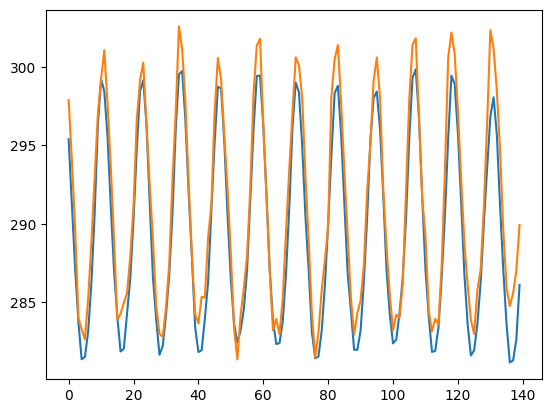

In [14]:
from matplotlib import pyplot as plt

predictions = model.predict(x_test_formatted)
predictions_df = pd.DataFrame(data=y_scaler.inverse_transform(predictions), columns=TARGET) # type: ignore
true_df = pd.DataFrame(data=y_scaler.inverse_transform(y_test_formatted), columns=TARGET) # type: ignore
plt.plot(predictions_df["soil_temperature_level_1"])
plt.plot(true_df["soil_temperature_level_1"])
true_df

In [15]:
def generate_data_from_seed(
    model: Sequential,
    x_scaler: StandardScaler,
    y_scaler: StandardScaler,
    seed_data: np.ndarray,
    future_climate_data_df: pd.DataFrame,
) -> pd.DataFrame:
    generated_data = []
    # (SEQ_LENGHT, len(FEATURES))
    current_step = seed_data
    year_col: list[int] = []
    month_col: list[int] = []
    for index, row in future_climate_data_df.iterrows():
        year, month = cast(pd.MultiIndex, index)
        year_col.append(year)
        month_col.append(month)
        # (SEQ_LENGHT, len(FEATURES))
        scaled_current_step = cast(
            np.ndarray,
            x_scaler.inverse_transform(current_step),
        )

        # (len(TARGET),)
        scaled_prediction = cast(np.ndarray, model(np.array([scaled_current_step])))[0]

        # (len(TARGET),)
        prediction = cast(
            np.ndarray, y_scaler.inverse_transform(np.array([scaled_prediction]))
        )[0]

        # (len(FEATURES),)
        enriched_prediction = np.concatenate([prediction, row.to_numpy()], axis=0)
        generated_data.append(enriched_prediction)

        current_step = np.concatenate(
            [current_step[1:], np.array([enriched_prediction])]
        )

    result = pd.DataFrame(data=generated_data, columns=FEATURES)
    result["year"] = year_col
    result["month"] = month_col

    result = result.set_index(keys=["year", "month"], drop=True)

    return result

In [16]:
filtered_past_climate_data = past_climate_data_df[FEATURES]
filtered_future_climate_data_df = future_climate_data_df.drop(
    columns=["latitude", "longitude"], errors="ignore"
)
print(
    f"filtered_future_climate_data_df.columns: {list(filtered_future_climate_data_df.columns)}"
)
print(f"filtered_future_climate_data_df.shape: {filtered_future_climate_data_df.shape}")
seed_data = filtered_past_climate_data[-12:]
start_year, start_month = filtered_past_climate_data.index[-1]

filtered_future_climate_data = future_climate_data_df[
    (
        (future_climate_data_df.index.get_level_values("year") > start_year)
        & (future_climate_data_df.index.get_level_values("month") > start_month)
    )
    | (
        (future_climate_data_df.index.get_level_values("year") == start_year)
        & (future_climate_data_df.index.get_level_values("month") > start_month)
    )
]

generated_data_df= generate_data_from_seed(
    model=model,
    x_scaler=x_scaler,
    y_scaler=y_scaler,
    seed_data=seed_data.to_numpy(),
    future_climate_data_df=filtered_future_climate_data_df,
)

# adjustments
# generated_data_df.loc[generated_data_df["snowfall"] < 0, "snowfall"] = 0


total_df = pd.concat([past_climate_data_df[-12:], generated_data_df])
total_df.reset_index()

filtered_future_climate_data_df.columns: ['sin_year', '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature', 'evaporation', 'total_precipitation', 'surface_pressure', 'surface_solar_radiation_downwards', 'surface_thermal_radiation_downwards']
filtered_future_climate_data_df.shape: (18, 9)


,year,month,soil_temperature_level_1,volumetric_soil_water_layer_1,sin_year,10m_u_component_of_wind,10m_v_component_of_wind,2m_temperature,evaporation,total_precipitation,surface_pressure,surface_solar_radiation_downwards,surface_thermal_radiation_downwards
0,2023,5,291.055034,0.260602,8.660254e-01,-0.102054,0.207749,290.999369,-0.002247,0.004094,99508.009995,1.924076e+07,2.972059e+07
1,2023,6,296.381550,0.210439,5.000000e-01,0.806400,-0.343088,296.363289,-0.003121,0.001812,99562.124655,2.417476e+07,3.151770e+07
2,2023,7,302.321289,0.094592,1.224647e-16,0.822240,0.538545,301.865479,-0.002881,0.000071,99599.008278,2.703156e+07,3.280618e+07
3,2023,8,301.161667,0.082745,-5.000000e-01,1.115998,-0.039338,300.134602,-0.002738,0.000192,99474.368448,2.334223e+07,3.221893e+07
4,2023,9,298.466328,0.104496,-8.660254e-01,0.242222,-1.113821,297.727707,-0.002481,0.001256,99775.061038,1.823291e+07,3.150182e+07
5,2023,10,294.682919,0.160957,-1.000000e+00,0.762563,0.686902,294.570205,-0.001950,0.001132,99838.061389,1.322789e+07,2.995108e+07
6,2023,11,289.537945,0.208539,-8.660254e-01,1.540843,0.958756,289.207760,-0.002278,0.003008,99367.500000,8.337317e+06,2.790652e+07
7,2023,12,285.898528,0.223046,-5.000000e-01,1.192037,-0.315470,285.686747,-0.001511,0.000471,99923.195917,6.814918e+06,2.605669e+07
8,2024,1,284.767290,0.226158,0.000000e+00,1.464902,-0.637662,284.485659,-0.001723,0.001416,100015.995353,7.378288e+06,2.548385e+07
9,2024,2,285.570629,0.203857,5.000000e-01,0.564335,0.520767,285.610095,-0.001290,0.002229,99883.250332,1.103211e+07,2.576133e+07


In [17]:
def plot_values(df: pd.DataFrame, values: list[str]):
    df_reset = df.reset_index()
    df_reset["YYYY-MM"] = (
        df_reset["year"].astype(str) + "-" + df_reset["month"].astype(str).str.zfill(2)
    )
    df_reset.plot(
        x="YYYY-MM",
        y=values,
        marker="o",
    )
    plt.xlabel("Month")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

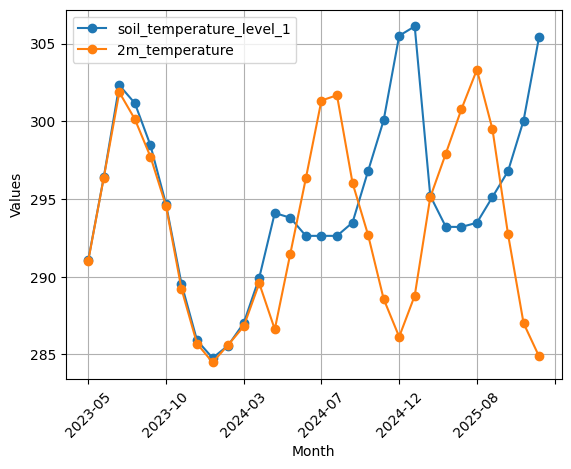

In [18]:
plot_values(df=total_df, values=["soil_temperature_level_1", "2m_temperature"])

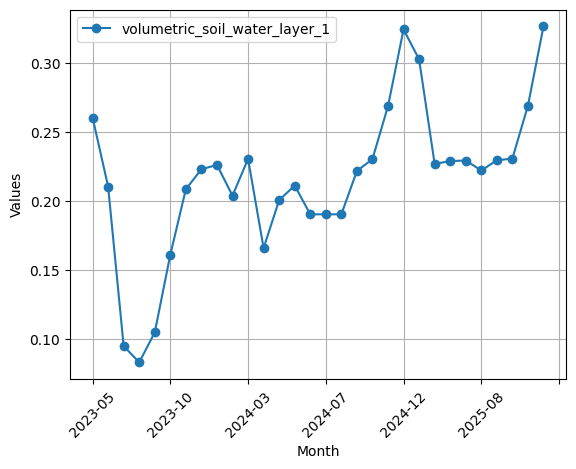

In [19]:
plot_values(df=total_df, values=["volumetric_soil_water_layer_1"])